<a href="https://colab.research.google.com/github/NikNord174/GAN_sandbox/blob/main/cGAN_Galaxis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#cGAN generated new galaxis 

In [1]:
!pip install astronn -q

In [2]:
from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
images, labels = load_galaxy10()

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set
/root/.astroNN/datasets/Galaxy10.h5 was found!


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Grayscale, RandomRotation, Resize
import PIL

class GalaxyDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images[:int(images.shape[0]/5.5)]
        self.labels = labels
        self.transform = Compose([RandomRotation(degrees=(-179, 179)),
                                  ToTensor()
                                  ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, indx):
        image = PIL.Image.fromarray(self.images[indx])
        image = self.transform(image)
        label = self.labels[indx]
        return image, label

galaxy = GalaxyDataset(images, labels)

In [4]:
import numpy as np

cl_indx = [] # indexes
for i in range(0,10): # for each class(10)
    for num, sample in enumerate(galaxy): 
        if sample[1] == i:
            cl_indx.append(num)
            break

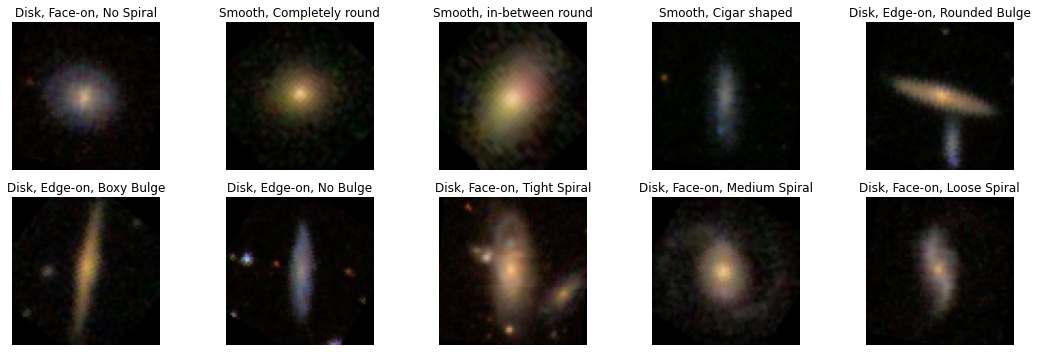

In [5]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(nrows=2, ncols=5, figsize=(15,5))
for num, indx in enumerate(cl_indx):
    if num < 5:
        row=0
    else:
        row=1
        num -= 5
    ax[row,num].imshow(galaxy[indx][0].permute(1,2,0))
    ax[row,num].set_title(galaxy10cls_lookup(galaxy[indx][1]))
    ax[row,num].axis('off')

plt.tight_layout()

In [6]:
image_shape=(3,69,69)
n_classes=10
embedding_dim=3
latent_dim=100

batch_size = 8
num_classes = 10

n_epochs = 2
lr = 0.02
b1=0.5
b2=0.999

In [7]:
train_loader=DataLoader(dataset=galaxy, batch_size=batch_size, shuffle=True)

In [8]:
galaxy.__len__()/8

495.0

In [34]:
from torch import nn
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.image_shape=image_shape

        self.embedding=nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                nn.Linear(embedding_dim,4*4))
        
        self.latent=nn.Sequential(nn.Linear(latent_dim,8192),
                                   nn.ReLU())

        self.model = nn.Sequential(nn.ConvTranspose2d(in_channels=513, 
                              out_channels=64*8,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*8),
                      nn.ReLU(),

                      nn.ConvTranspose2d(in_channels=64*8, 
                              out_channels=64*4,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*4),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*4, 
                              out_channels=64*2,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*2),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*8, 
                              out_channels=64*4,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*4),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*4, 
                              out_channels=64*2,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*2),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*2, 
                              out_channels=64*1,
                              kernel_size=4,
                              stride=2,
                              padding=60,),
                      nn.BatchNorm2d(64*1),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*1, 
                              out_channels=3,
                              kernel_size=4,
                              stride=1,
                              padding=36,
                              dilation=1),
                      nn.Tanh())

    def forward(self, inputs):
      noise_vector,labels=inputs
      latent_output = self.latent(noise_vector)
      latent_output=latent_output.view(-1,512,4,4)
      labels=torch.tensor(labels).long()
      labels_output=self.embedding(labels)
      labels_output=labels_output.view(-1,1,4,4)
      print(latent_output.size(),labels_output.size())
      output=torch.cat((latent_output,labels_output),dim=1)
      image = self.model(output)
      return image

In [35]:
for ind, (im,lab) in enumerate(train_loader):
  noise_vector=torch.randn(im.size(0),latent_dim)
  a=Generator().forward((noise_vector,lab))
  print(a.size())
  break

torch.Size([8, 512, 4, 4]) torch.Size([8, 1, 4, 4])
torch.Size([8, 128, 32, 32])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [11]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.embedding=nn.Sequential(
        nn.Embedding(n_classes, embedding_dim)
        )
    
    self.model=nn.Sequential(nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2, inplace=True))
    
    self.linear_model=nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(8195,1),
            nn.Sigmoid())
    

  def forward(self, inputs):
      image,label=inputs

      label=torch.tensor(label).long()
      label_output=self.embedding(label)
      image = self.model(image)
      image=image.view(batch_size,-1)
      #label_output=label_output.view(8,-1)
      output=torch.cat((image,label_output),dim=1)
      image = self.linear_model(output)
      return image

In [12]:
adversarial_loss=nn.BCELoss()

def generator_loss(fake_output,label):
  gen_loss=adversarial_loss(fake_output,label)
  return gen_loss

def discriminator_loss(output,label):
  disc_loss=adversarial_loss(output,label)
  return disc_loss

In [13]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))

In [14]:
def train(generator, discriminator, 
          D_optimizer, G_optimizer,
          train_loader,
          n_epochs,
          device):

    D_loss_plot=[]
    G_loss_plot=[]

    for epoch in range(1,n_epochs+1):
      D_loss_list=[]
      G_loss_list=[]

      n_batch=0
      for _, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        n_batch+=1
        print(n_batch)
        real_images = real_images.to(device)
        labels = labels.to(device)

        real_target = torch.ones(real_images.size(0),1).to(device)
        fake_target = torch.zeros(real_images.size(0),1).to(device)

        noise_vector = torch.randn(real_images.size(0),latent_dim)
        noise_vector = noise_vector.to(device)

        conditional = torch.randint(0,10,(batch_size,))
        conditional = conditional.to(device)
        generated_images = generator((noise_vector,conditional))
        generated_images=generated_images.to(device)

        # Train with real.
        real_output = discriminator((real_images,labels))
        D_loss_real = discriminator_loss(real_output,real_target)

        # Train with fake.
        fake_output = discriminator((generated_images.detach(),labels))
        D_loss_fake = discriminator_loss(fake_output,fake_target)

        D_loss = (D_loss_real+D_loss_fake)/2
        D_loss_list.append(D_loss)
        D_loss.backward(retain_graph=True)
        D_optimizer.step()

        G_optimizer.zero_grad()
        generated_images = generator((noise_vector,labels)).detach()
        fake_output = discriminator((generated_images.detach(),labels))
        G_loss = generator_loss(fake_output,real_target)
        G_loss.backward()
        G_optimizer.step()
        G_loss_list.append(G_loss)

        G_optimizer.zero_grad()
        D_optimizer.zero_grad()
        

      D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
      G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))

      print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' %(epoch,n_epochs,
                                                       torch.mean(torch.FloatTensor(D_loss_list)),
                                                       torch.mean(torch.FloatTensor(G_loss_list))))
      
      save_image(generated_images.data,'/content/results/sample_%d'%epoch + '.png')

In [19]:
!mkdir results

In [ ]:
import torch
torch.cuda.empty_cache()

In [15]:
from torchvision.utils import save_image

train(generator, discriminator, 
          D_optimizer, G_optimizer,
          train_loader, n_epochs, device)

1
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
